Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.038229779850563556..1.0000000000028586].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.038229779850563556..1.0000000000028586].


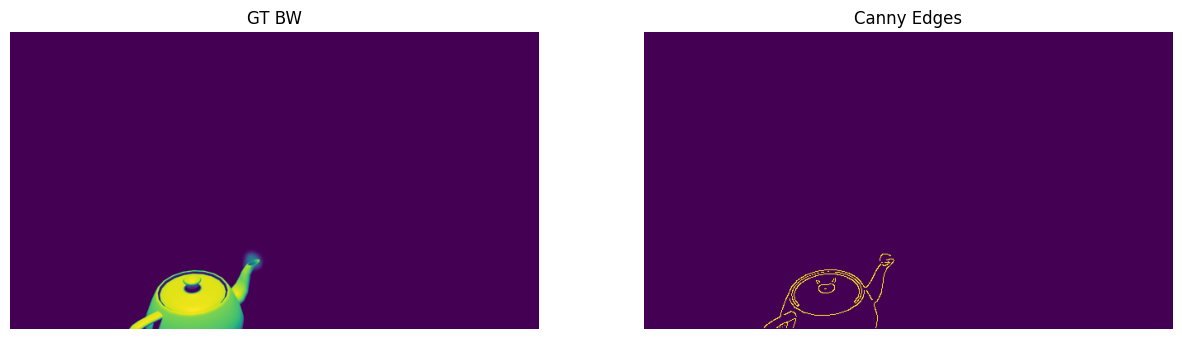

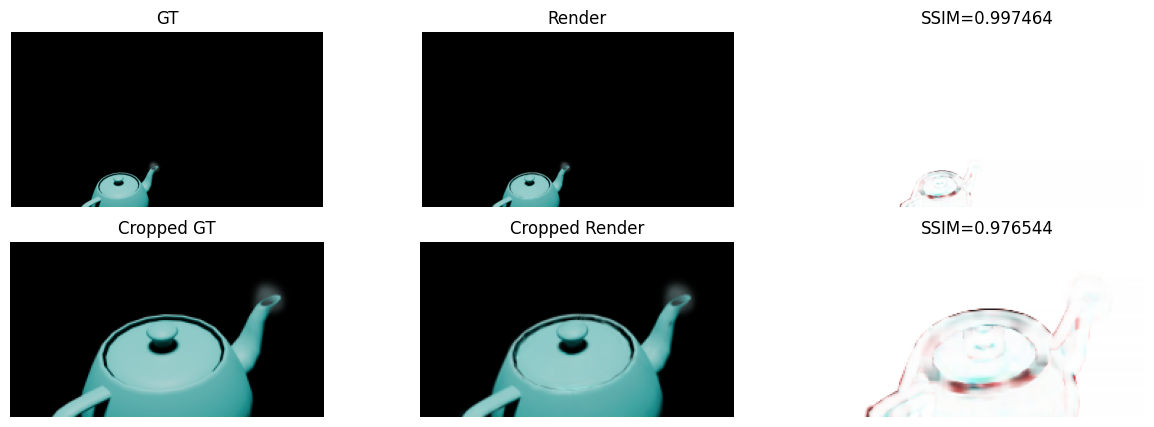

In [13]:
# canny filter contour extraction
from matplotlib.axes import Axes
from skimage import feature
from skimage.color import rgb2gray
import skimage as skim
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

gt = skim.io.imread("/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/gt/00000.png")
gt_bw = rgb2gray(gt)
edges: np.ndarray = feature.canny(gt_bw)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, title, image in zip(axs, ["GT BW", "Canny Edges"], [gt_bw, edges]):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image)


def crop_to_edges(image: np.ndarray, edges: np.ndarray, padding=0) -> np.ndarray:
    y, x = np.where(edges)
    return image[y.min() - padding:y.max() + padding,  x.min() - padding: x.max() + padding]

render = skim.io.imread("/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/renders/00000.png")
axs: np.ndarray[Axes]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

ssim_metrics, ssim_image = ssim(
    gt, render, channel_axis=2, data_range=gt.max() - gt.min(), full=True)
for ax, title, image in zip(axs[0,:], ["GT", "Render", f"SSIM={ssim_metrics:.6f}"], [gt, render, ssim_image]):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image)


render = skim.io.imread("/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/renders/00000.png")
cropped_render = crop_to_edges(render, edges, 30)
cropped_gt = crop_to_edges(gt, edges, 30)
ssim_metrics, ssim_image = ssim(
    cropped_gt, cropped_render, channel_axis=2, data_range=cropped_gt.max() - cropped_gt.min(), full=True)
for ax, title, image in zip(axs[1,:], ["Cropped GT", "Cropped Render", f"SSIM={ssim_metrics:.6f}"], [cropped_gt, cropped_render, ssim_image]):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image)

In [10]:
import pathlib
import functools
from timeit import timeit
from typing import Any, Callable


def ssim_full(**kwargs):
    return ssim(
        gt, render, channel_axis=2, data_range=gt.max() - gt.min(), **kwargs)


def ssim_edge_crop(**kwargs):
    gt_bw = rgb2gray(gt)
    edges: np.ndarray = feature.canny(gt_bw)
    cropped_render = crop_to_edges(render, edges, 30)
    cropped_gt = crop_to_edges(gt, edges, 30)
    return ssim(
        cropped_gt, cropped_render, channel_axis=2, data_range=cropped_gt.max() - cropped_gt.min(), **kwargs)


def memoize_custom_hash(func, custom_hash):
    cache = {}

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        key = custom_hash(*args, **kwargs)
        return cache.setdefault(key, func(*args, **kwargs))
    return wrapper


def hash_ndarray(array: np.ndarray):
    return hash(array.tobytes())


def find_edges(gt: np.ndarray):
    gt_bw = rgb2gray(gt)
    edges: np.ndarray = feature.canny(gt_bw)
    return edges


find_edges = memoize_custom_hash(find_edges, hash_ndarray)


def ssim_cached_edge_crop():
    edges = find_edges(gt)
    cropped_render = crop_to_edges(render, edges, 30)
    cropped_gt = crop_to_edges(gt, edges, 30)
    return ssim(
        cropped_gt, cropped_render, channel_axis=2, data_range=cropped_gt.max() - cropped_gt.min())


test = (ssim_full(), ssim_edge_crop(), ssim_cached_edge_crop())
print("SSIMs:", test)
eps = 1e-6
for t in test[1:]:
    assert test[1]-eps < t < test[1]+eps, f"SSIM values are not equal: {test}"

gts = [plt.imread(f) for f in sorted(pathlib.Path(
    "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/gt").glob("*.png"))]
renders = [plt.imread(f) for f in sorted(pathlib.Path(
    "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/renders").glob("*.png"))]
for i, (gt, render) in enumerate(zip(gts, renders)):
    test = (ssim_full(), ssim_edge_crop(), ssim_cached_edge_crop())
    print(f"SSIMs of {i}:", test)

number = int(1e3)
times = (
    timeit(
        setup="from __main__ import ssim_full",
        stmt="""ssim_full()""",
        number=number,
    ),
    timeit(
        setup="from __main__ import ssim_edge_crop",
        stmt="""ssim_edge_crop()""",
        number=number,
    ),
    timeit(
        setup="from __main__ import ssim_cached_edge_crop",
        stmt="""ssim_cached_edge_crop()""",
        number=number,
    ),
)
for t, expname in zip(times, ("ssim_full", "ssim_edge_crop", "ssim_cached_edge_crop")):
    print(f"{expname:30}: {t:.6f} seconds")

SSIMs: (np.float64(0.9974640147665917), np.float64(0.9765437303999912), np.float64(0.9765437303999912))
SSIMs of 0: (np.float32(0.99746394), np.float32(0.9765435), np.float32(0.9765435))
SSIMs of 1: (np.float32(0.9975922), np.float32(0.97792166), np.float32(0.97792166))
SSIMs of 2: (np.float32(0.9976937), np.float32(0.97885203), np.float32(0.97885203))
SSIMs of 3: (np.float32(0.99774307), np.float32(0.9794812), np.float32(0.9794812))
SSIMs of 4: (np.float32(0.99774456), np.float32(0.9796687), np.float32(0.9796687))
SSIMs of 5: (np.float32(0.99776906), np.float32(0.98005885), np.float32(0.98005885))
SSIMs of 6: (np.float32(0.99777126), np.float32(0.9800785), np.float32(0.9800785))
SSIMs of 7: (np.float32(0.99776435), np.float32(0.9801832), np.float32(0.9801832))
SSIMs of 8: (np.float32(0.99768335), np.float32(0.9796352), np.float32(0.9796352))
SSIMs of 9: (np.float32(0.9976812), np.float32(0.97978336), np.float32(0.97978336))
SSIMs of 10: (np.float32(0.99760216), np.float32(0.97926444),